# Notebook to calculate how much area needs to be investigated to map side walks in Oregon state

Install library

In [ ]:
# !pip install osmnx networkx
# !pip install osmnx matplotlib
# !pip install geopandas
# !pip install rasterio

c:\Users\varun\anaconda3\envs\myenv\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\varun\anaconda3\envs\myenv\lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 115 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


MultiDiGraph with 212435 nodes and 533201 edges


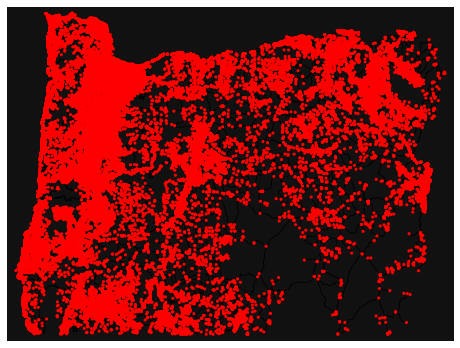

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Set the place name (Oregon state)
place_name = "Oregon, USA"

# Download the road network for Oregon (filtering only driveable roads)
G = ox.graph_from_place(place_name, network_type='drive')

# Display basic information about the network, prinitng can take some time
#print(nx.info(G))

# Save the road network as a shapefile
ox.save_graph_shapefile(G, filepath='oregon_roads_shapefile')
# Alternatively, save as a GeoPackage
ox.save_graph_geopackage(G, filepath='oregon_roads.gpkg', encoding='utf-8')

# DOWNLOAD HIGWAY DATA WHERE MY SIDE WALKS WILL NOT BE PRESENT (mainly interstate highways). We are doing this becasue sidewalks are not present on highways

In [ ]:
# COMMENTING NOW AS IT TAKES FOREVER


# # Custom filter to exclude interstate highways and roads without sidewalks
# custom_filter_exclude_highways = (
#     '["highway"!~"motorway|trunk|primary"]'  # Exclude interstates and major highways
    
# )

# # Download the road network for Oregon with the custom filter
# G_exclude_highway = ox.graph_from_place(place_name, network_type='drive', custom_filter=custom_filter_exclude_highways)

# # Display basic information about the network
# print(nx.info(G_exclude_highway))

# # Save the avoid highwasy as a shapefile
# ox.save_graph_shapefile(G_exclude_highway, filepath='oregon_roads_shapefile')
# # Alternatively, save as a GeoPackage
# ox.save_graph_geopackage(G_exclude_highway, filepath='oregon_roads.gpkg', encoding='utf-8')


# HERE we are visualizing data using folium library

In [ ]:
import folium
import geopandas as gpd

# Load your shapefile using GeoPandas
shapefile_path = r'D:\task\oregon_roads_shapefile\edges.shp'  # Replace with your path
gdf = gpd.read_file(shapefile_path)

# Get the center of the map (mean of coordinates)
center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]

# Create a Folium map centered at the shapefile's location
m = folium.Map(location=center, zoom_start=10)

# Add the GeoDataFrame to the map as a GeoJson layer
geojson_layer = folium.GeoJson(
    gdf,
    name='Shapefile Layer',
    style_function=lambda feature: {
        'fillColor': 'blue',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.5,
    }
).add_to(m)

# Add Layer Control (directly from folium, not folium.plugins)
folium.LayerControl().add_to(m)

# Display the map in the notebook
m


c:\Users\varun\anaconda3\envs\myenv\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\varun\AppData\Local\Temp\ipykernel_12248\2705972037.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]


# Current shapefiles are in wgs1984 projection system which is geographic lat long in decimal degrees, we need to reproject to UTM zone 10 to convert to meter. We are doing this to create a buffer of 12 feet long the road where my potential sidewalk will be present

In [5]:
import geopandas as gpd

# Load the shapefile
shapefile_path = r'D:\task\oregon_roads_shapefile\edges.shp'
gdf = gpd.read_file(shapefile_path)

# Check the current CRS (should be WGS84)
print(f"Original CRS: {gdf.crs}")

# Reproject to a UTM zone (Oregon falls in UTM Zone 10N - EPSG:32610)
gdf_projected = gdf.to_crs(epsg=32610)  # UTM uses meters

# Convert 12 feet to meters (1 foot = 0.3048 meters)
buffer_distance = 24 * 0.3048  # 12 feet in meters

# Apply the buffer in the projected CRS
gdf_projected['geometry'] = gdf_projected.geometry.buffer(buffer_distance)

# Reproject back to WGS84 (optional, if you need the final output in lat/lon)
gdf_buffered = gdf_projected.to_crs(epsg=32610)

# Calculate the area of each buffered geometry (in square meters)
gdf_projected['buffered_area_m2'] = gdf_projected.geometry.area

# Print the total area of all buffered geometries (in square meters and km2)
total_area_m2 = gdf_projected['buffered_area_m2'].sum()
total_km2 = total_area_m2 / 10_00000  # 1 km2 = 10,00000 m²

print(f"Total Buffered Area: {total_area_m2:.2f} m² ({total_km2:.2f} km2)")

# Save the buffered shapefile
output_path = r'D:\task\oregon_roads_shapefile\edges_buffered.shp'
gdf_buffered.to_file(output_path)

print(f"Buffered shapefile saved at: {output_path}")

Original CRS: epsg:4326
Total Buffered Area: 1746398971.62 m² (1746.40 km2)
Buffered shapefile saved at: D:\task\oregon_roads_shapefile\edges_buffered.shp


# EXTRACT 25, 26 and 27 class which are urban areas from land cover as these are urban areas

In [6]:
import rasterio
import numpy as np
# Define the path to your NLCD raster file
nlcd_path = r'D:\task\NLCD_2016_Land_Cover_OR/NLCD_landcover2016.tif'

# Open the NLCD raster using Rasterio
with rasterio.open(nlcd_path) as src:
    nlcd_data = src.read(1)  # Read the first (and only) band
    profile = src.profile    # Store profile for saving the output

# Define the classes to extract urban settlement (e.g., 21, 22, 23, 24)
classes_to_extract = [21, 22, 23, 24]

# Create a mask where the values belong to the urban settlement classes
mask = np.isin(nlcd_data, classes_to_extract)

# Extract only the desired classes, set others to 0 (or NoData)
extracted_data = np.where(mask, nlcd_data, 0)


# Update the profile for the output raster
profile.update(
    dtype=rasterio.uint8,  # Ensure correct data type
    count=1,               # Single band output
    nodata=0               # Set NoData value to 0 for clarity
)

# Define the path for the extracted output raster
output_path = r'D:\task\NLCD_2016_Land_Cover_OR\NLCD_extracted_classes.tif'

# Save the extracted data to a new raster file
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(extracted_data, 1)  # Write the data to the first band

print(f"Extracted raster saved successfully at: {output_path}")

Extracted raster saved successfully at: D:\task\NLCD_2016_Land_Cover_OR\NLCD_extracted_classes.tif


# EXTRACT INTERSCTION BETWEEN BUFFER ROAD AND LANDCOVER URBAN AREAS (It didnt work as the land cover was pretty low resolution. I imported landcover map from this link: https://geohub.oregon.gov/documents/9bbaa64718774bbfbf5c6ade0edf86d3/about and used to find the common area between raod buffer and urban areas as agriculture, rural, forest will not have cross walks)

In [9]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import shape
import numpy as np

# Define paths for inputs and output
raster_path = r'D:\task\NLCD_2016_Land_Cover_OR\NLCD_extracted_classes.tif'  # Extracted raster
shapefile_path = r'D:\task\oregon_roads_shapefile\edges_buffered.shp'  # Your shapefile
output_shapefile = r'D:\task\common_area.shp'  # Output shapefile path

# Step 1: Load the shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

# Step 2: Ensure the CRS of the shapefile matches the raster's CRS
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)

# Step 3: Extract geometries from the shapefile for masking
geometries = [feature["geometry"] for feature in gdf.__geo_interface__["features"]]

# Step 4: Mask the raster with the shapefile geometries
with rasterio.open(raster_path) as src:
    masked_data, masked_transform = mask(src, geometries, crop=True)

# Step 5: Convert the masked raster to polygons
polygons = list(
    shapes(masked_data[0], mask=masked_data[0] != 0, transform=masked_transform)
)

# Step 6: Create a GeoDataFrame from the polygons
gdf_common = gpd.GeoDataFrame(
    [{'geometry': shape(geom), 'value': value} for geom, value in polygons],
    crs=raster_crs
)

# Step 7: Save the GeoDataFrame as a shapefile
gdf_common.to_file(output_shapefile)

print(f"Common area shapefile saved successfully at: {output_shapefile}")



Common area shapefile saved successfully at: D:\task\common_area.shp
